In [5]:
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
import dijkstra

States form a 3x3 grid, start state is the middle. Actions are go up, down, right, left, stay.

In [6]:
class Agent():
    def __init__(self, goal):
        self.goal = np.array(goal)
        self.loc = np.array([0,0])
        self.ACTIONS = [0, 1, 2, 3, 4]

    def get_action_distr(self, loc):
        distr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
#         test_dists = [np.linalg.norm(self.goal - loc + np.array([0,1])),
#                       np.linalg.norm(self.goal - loc + np.array([0,-1])),
#                       np.linalg.norm(self.goal - loc + np.array([1,0])),
#                       np.linalg.norm(self.goal - loc + np.array([-1,0])),
#                       np.linalg.norm(self.goal - loc)
#                      ]
#         direction = np.argmin(test_dists)
#         distr[direction] = 1.0
        if loc[1] == self.goal[1] and loc[0] == self.goal[0]:
            distr[4] = 1.0
        elif loc[1] < self.goal[1]:
            distr[0] = 1.0
        elif loc[1] > self.goal[1]:
            distr[1] = 1.0
        elif loc[0] < self.goal[0]:
            distr[2] = 1.0
        else:
            distr[3] = 1.0
        return distr
    
    
    def move(self, distr):
        action = np.random.choice(self.ACTIONS, 1, p=distr)[0]
        if action == 0:
            self.loc[1] += 1
        elif action == 1:
            self.loc[1] -= 1
        elif action == 2:
            self.loc[0] += 1
        else:
            self.loc[0] -= 1
            
class MazeAgent():
    import collections

    def __init__(self, goal, walls, size):
        self.size = size
        self.goal = goal
        self.loc = np.array([0,0])
        self.graph = self.make_graph(walls)
        self.ACTIONS = [0, 1, 2, 3, 4]

    def get_action_distr(self, loc):
        distr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
        best_action = self.find_move_from_state(start=loc, state=self.find_optimal_first_move(loc))
        distr[best_action] = 1.0
        return distr
    
    # TODO: make states an enum
    def find_move_from_state(self, start, state):
        #make sure we only differ in one position by one move
        #NOTE! != is xor for booleans in python
        assert bool((start[0]-state[0])**2 == 1) != bool((start[1]-state[1])**2 == 1)
        if state[1] == start[1] - 1:
            return 0 # up
        elif state[1] == start[1] + 1:
            return 1 # down
        elif state[0] == start[0] + 1:
            return 2 # right
        elif state[0] == start[0] - 1:
            return 3 # left
        else:
            raise ValueError("bad states")
    
    def find_optimal_first_move(self, start):
        _, paths_back = self.graph.dijkstra(start)
        # starting with a dictionary of nodes to adjacent nodes closest to start, walk back to find best first move
        second_state = self.goal
        last_state = paths_back[self.goal]
        while last_state is not start:
            second_state = last_state
            last_state = paths_back[last_state]
        return second_state
    
    def make_graph(self, walls):
        x_coords = list(range(self.size))
        y_coords = list(range(self.size))
        states = []
        for start_x in x_coords:
            for start_y in y_coords:
                states.append((start_x, start_y))
                
        graph = dijkstra.Digraph(nodes=states)
        for start_x in x_coords:
            for start_y in y_coords:
                start = (start_x, start_y)
                left = (start_x-1, start_y)
                right = (start_x+1, start_y)
                up = (start_x, start_y+1)
                down = (start_x, start_y-1)
                
                if start_x - 1 >= 0 and left not in walls:
                    graph.addEdge(start, left, 1)
                if start_x + 1 < self.size and right not in walls:
                    graph.addEdge(start, right, 1)
                if start_y - 1 >= 0 and down not in walls:
                    graph.addEdge(start, down, 1)
                if start_x + 1 < self.size and up not in walls:
                    graph.addEdge(start, up, 1)
        return graph
                
    
    def move(self, distr):
        action = np.random.choice(self.ACTIONS, 1, p=distr)[0]
        if action == 0:
            self.loc[1] += 1
        elif action == 1:
            self.loc[1] -= 1
        elif action == 2:
            self.loc[0] += 1
        else:
            self.loc[0] -= 1
            
class NoisyMazeAgent(MazeAgent):
    def __init__(self, goal, walls, size, opt_prob):
        self.opt_prob = opt_prob
        self.noise = (1-opt_prob)/4
        MazeAgent.__init__(self, goal, walls, size)
        
    def get_action_distr(self, loc):
        no_noise = list(MazeAgent.get_action_distr(self, loc))
        print(no_noise)
        noisy = no_noise
        for index, elem in enumerate(no_noise):
            if no_noise[index] == 1:
                noisy[index] = self.opt_prob
            else:
                noisy[index] = self.noise
        return noisy

        
def DiscreteJSD(P, Q):
    M = (P + Q)/2
    return (entropy(P, M) + entropy(Q, M))/2

In [7]:
class NoisyAgent(Agent):
    def __init__(self, goal, opt_prob):
        self.opt_prob = opt_prob
        self.noise = (1-opt_prob)/4
        Agent.__init__(self, goal)
        
    def get_action_distr(self, loc):
        distr = [self.noise, self.noise, self.noise, self.noise, self.noise]
        test_dists = [np.linalg.norm(self.goal - loc + np.array([0,1])),
                      np.linalg.norm(self.goal - loc + np.array([0,-1])),
                      np.linalg.norm(self.goal - loc + np.array([1,0])),
                      np.linalg.norm(self.goal - loc + np.array([-1,0])),
                      np.linalg.norm(self.goal - loc)
                     ]
        direction = np.argmin(test_dists)
        distr[direction] = self.opt_prob
#         if loc[1] == self.goal[1] and loc[0] == self.goal[0]:
#             distr[4] = self.opt_prob
#         elif loc[1] < self.goal[1]:
#             distr[0] = self.opt_prob
#         elif loc[1] > self.goal[1]:
#             distr[1] = self.opt_prob
#         elif loc[0] < self.goal[0]:
#             distr[2] = self.opt_prob
#         else:
#             distr[3] = self.opt_prob
        return np.array(distr)

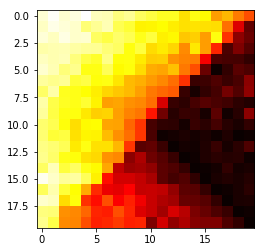

In [8]:
heatmapD = np.zeros((20, 20))
for j in np.arange(-10,10):
    for k in np.arange(-10, 10):
        averages = []
        for a in range(10):
            N = NoisyAgent([5, 5], .75)
            S = NoisyAgent([j, k], .75)
            divergences = []
            for i in range(20):
                p1 = N.get_action_distr(N.loc)
                q1 = S.get_action_distr(N.loc)
                p2 = N.get_action_distr(S.loc)
                q2 = S.get_action_distr(S.loc)
                divergences.append( ((DiscreteJSD(p1, q1) ** (.5)) + (DiscreteJSD(p2, q2) ** (.5)))/2)
                N.move(p1)
                S.move(q2)
            averages.append(sum(divergences)/len(divergences))
        heatmapD[j + 10, k + 10] = sum(averages)/len(averages)
plt.imshow(heatmapD, cmap='hot', interpolation='nearest')
plt.show()


In [9]:
heatmapD[17, 18]

0.01317433542139912

In [6]:
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

class CAgent():
    def __init__(self, goal):
        self.speed_lim = .25
        self.speed_std = .4
        self.angle_std = .4
        self.goal = np.array(goal)
        self.loc = np.array([0.0,0.0])

    def get_action_distr(self, loc):
        vec = self.goal - loc
        dist = np.linalg.norm(vec)
        if dist >= self.speed_lim:
            mu_speed = self.speed_lim
        else:
            mu_speed = dist
        if dist == 0:
            return ((0, self.speed_std), (0, self.angle_std))
        vec = vec/dist
        mu_angle = angle_between(vec, np.array([1, 0]))
        if (vec[1] < 0):
            mu_angle = mu_angle * -1
            
        return ((mu_speed, self.speed_std), (mu_angle, self.angle_std))

    def move(self, distr):
        mu_speed, sgm_speed = distr[0]
        mu_angle, sgm_angle = distr[1]
        dist = np.random.normal(mu_speed, sgm_speed)
        angle = np.random.normal(mu_angle, sgm_angle)
        self.loc += np.array(pol2cart(dist, angle))
        
def GaussKL(mu_p, mu_q, sgm_p, sgm_q):    
    return (np.log(np.linalg.det(sgm_q)) - np.log(np.linalg.det(sgm_p)) - mu_p.shape[0]
            + np.trace(np.linalg.inv(sgm_q) @ sgm_p) +
            (mu_q - mu_p).reshape(1, mu_p.shape[0]) @ np.linalg.inv(sgm_q) @ 
            (mu_q - mu_p).reshape(mu_p.shape[0], 1)
           )/2

def GaussSymmetricKL(P, Q):
    mu_p, sgm_p = P
    mu_q, sgm_q = Q
    return (GaussKL(mu_p, mu_q, sgm_p, sgm_q) + GaussKL(mu_q, mu_p, sgm_q, sgm_p))/2

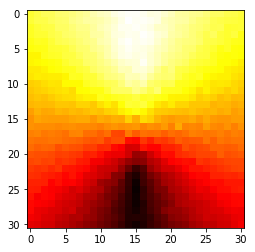

In [7]:
heatmap = np.zeros((31, 31))
for j in np.arange(-15,16):
    for k in np.arange(-15, 16):
        averages = []
        for a in range(10):
            N = CAgent([10, 0])
            S = CAgent([j, k])
            divergences = []
            for i in range(30):
                p1 = N.get_action_distr(N.loc)
                q1 = S.get_action_distr(N.loc)
                p2 = N.get_action_distr(S.loc)
                q2 = S.get_action_distr(S.loc)
                mu_p1 = np.array([p1[0][0], p1[1][0]])
                mu_q1 = np.array([q1[0][0], q1[1][0]])
                mu_p2 = np.array([p2[0][0], p2[1][0]])
                mu_q2 = np.array([q2[0][0], q2[1][0]])
                sgm_p1 = np.array([[p1[0][1], 0], [0, p1[1][1]]])
                sgm_q1 = np.array([[q1[0][1], 0], [0, q1[1][1]]])
                sgm_p2 = np.array([[p2[0][1], 0], [0, p2[1][1]]])
                sgm_q2 = np.array([[q2[0][1], 0], [0, q2[1][1]]])
                divergences.append( (GaussSymmetricKL((mu_p1, sgm_p1), (mu_q1, sgm_q1))**.5 +
                                     GaussSymmetricKL((mu_p2, sgm_p2), (mu_q2, sgm_q2))**.5
                                    ) / 2)
                N.move(p1)
                S.move(q2)
            averages.append(sum(divergences)/len(divergences))
        heatmap[j+15, k+15] = sum(averages)/len(averages)

plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.show()

In [8]:
import tensorflow as tf

x1 = tf.placeholder(tf.float32, [None, 2], "task_1")
x2 = tf.placeholder(tf.float32, [None, 2], "task_2")
y = tf.placeholder(tf.float32, [None, 1], "labels")

initer = tf.truncated_normal_initializer(stddev=0.01) 
W1 = tf.Variable(dtype=tf.float32, shape=[2, 4], initializer=initer, name="weights_1")
b1 = tf.Variable(dtype=tf.float32, shape=[4], initializer=initer, name="weights_1")
W2 = tf.Variable(dtype=tf.float32, shape=[4, 2], initializer=initer, name="weights_1")
b2 = tf.Variable(dtype=tf.float32, shape=[2], initializer=initer, name="weights_1")

net1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x1, W1), b1))
net1 = tf.nn.bias_add(tf.matmul(net1, W2), b2)

net2 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x2, W1), b1))
net2 = tf.nn.bias_add(tf.matmul(net2, W2), b2)

eucd2 = tf.pow(tf.subtract(net1, net2), 2)
eucd2 = tf.reduce_sum(eucd2, 1)
eucd = tf.sqrt(eucd2+1e-6, name="eucd")


loss = tf.nn.sigmoid_cross_entropy_with_logits(logits)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TypeError: __init__() got an unexpected keyword argument 'shape'

In [8]:
maximum_displacement = 21
num_threads = 5
for num in range(num_threads):
    spacing = (2*maximum_displacement+1)//num_threads; 
    start_disp = -maximum_displacement + spacing*num
    end_disp = -maximum_displacement + spacing*(num+1)
    if(end_disp + spacing > maximum_displacement):
        end_disp = maximum_displacement
    print("({}, {})", start_disp, end_disp)

({}, {}) -21 -13
({}, {}) -13 -5
({}, {}) -5 3
({}, {}) 3 11
({}, {}) 11 21


In [24]:
def table_dim(n):
    if(n == 1):
        return [0]*5
    else:
        return [table_dim(n-1) for _ in range(5)]
table = table_dim(4)

def children(hands):
    l1, r1, l2, r2 = hands
    child_set = set()
    if(r1 == 0 and l1 %2 == 0 and l1 > 0):
        child_set.add((l2, r2, l1 // 2, l1//2))
    elif(l1 == 0 and r1 %2 == 0 and r1 > 0):
        child_set.add((l2, r2, r1 // 2, r1//2))
        
    if(l1 > 0):
        child_set.add(((l2+l1)%5, r2, l1, r1))
        child_set.add((l2, (r2+l1)%5, l1, r1))
    if(r1 > 0):
        child_set.add(((l2+r1)%5, r2, l1, r1))
        child_set.add((l2, (r2+r1)%5, l1, r1))
    return child_set
        
def parents(hands):
    l1, r1, l2, r2 = hands
    parent_set = set()
    #Account for splits
    if(l2 == r2 and l2 < 3):
        parent_set.add((l2+r2, 0, l1, r1))
        parent_set.add((0, l2+r2, l1, r1))
    #Account for l2 being used
    if(l2 > 0):
        parent_set.add((l2, r2, (l1-l2)%5, r1))
        parent_set.add((l2, r2, l1, (r1-l2)%5))
    if(r2 > 0):
        parent_set.add((l2, r2, (l1-r2)%5, r1))
        parent_set.add((l2, r2, l1, (r1-r2)%5))
    return parent_set


print(children((1, 2, 1, 1)))
print(parents((1, 2, 1, 1)))
to_update = set()
#Initialize to_update with parents of instantly losing positions
for i in range(5):
    for j in range(5):
        if(not (i == 0 and j == 0)):
            table[0][0][i][j] = -1
            to_update.update(parents((0, 0, i, j)))
            
while(to_update):
    hand = to_update.pop()
    hl1, hr1, hl2, hr2 = hand
    #continue of hand has already been filled in
    if(table[hl1][hr1][hl2][hr2] != 0):
        continue
    hand_parents = parents(hand)
    winning = 0
    child_set = children(hand)
    for child in child_set:
        l1, r1, l2, r2 = child
        if(table[l1][r1][l2][r2] < 0):
            table[hl1][hr1][hl2][hr2] = 1
            to_update.update(hand_parents)
            break
        if(table[l1][r1][l2][r2] > 0):
            winning += 1
    if(winning == len(child_set)):
        table[hl1][hr1][hl2][hr2] = -1
        to_update.update(hand_parents)

print(table[2][2][3][3])
            



{(1, 2, 1, 2), (3, 1, 1, 2), (1, 3, 1, 2), (2, 1, 1, 2)}
{(2, 0, 1, 2), (1, 1, 0, 2), (1, 1, 1, 1), (0, 2, 1, 2)}
1


In [26]:
def get_move(hand):
    hand_children = children(hand)
    saved = None
    for child in hand_children:
        l1, r1, l2, r2 = child
        if(table[l1][r1][l2][r2] < 0):
            return child
        elif(table[l1][r1][l2][r2] == 0):
            saved = child
    if(saved):
        return saved
    else:
        return hand_children.pop()

(2, 1, 1, 1)

In [33]:
get_move((0, 2, 0, 3))

(0, 0, 0, 2)

In [36]:
# Returns True if A contains item and False otherwise
def binary_search(A, item):
    if len(A) == 0:
        return False
    else:
        middle = len(A) // 2
        if A[middle] == item:
            return True
        if(A[middle] > item):
        #A[:middle] is a copy of the elements of A to the left of middle
            return binary_search(A[:middle], item)
        else:
        #A[middle+1:] is a copy of the elements of A to the right of middle
            return binary_search(A[middle + 1:], item)
list = [1, 2, 3, 5, 8, 22, 34, 42, 87, 103]
print(binary_search(list, 4))
print(binary_search(list, 42))

False
True
